1er graphique, qui illustre l'import net en fonction du pays, de 2021 à 2023

In [1]:
import matplotlib
print(matplotlib.__version__)

3.8.2


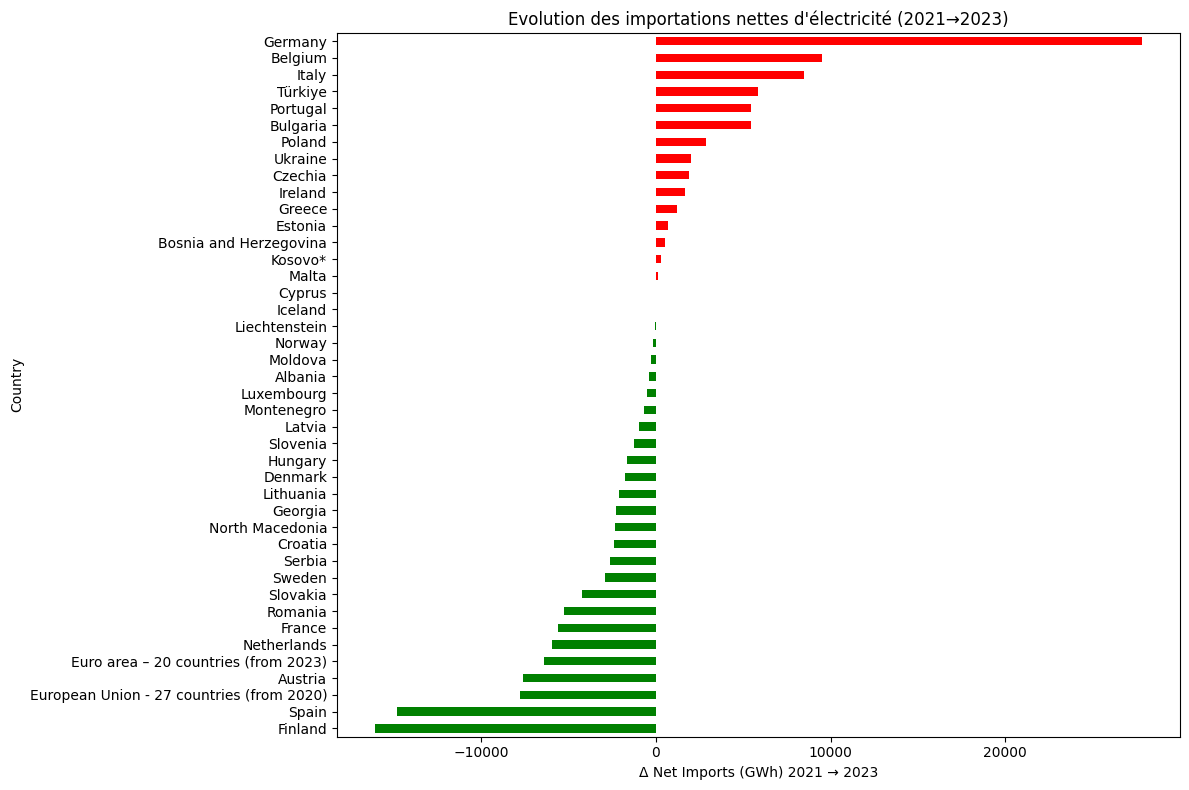

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load only needed columns to speed things up
usecols = ["freq", "nrg_bal", "geo", "TIME_PERIOD", "OBS_VALUE"]
df = pd.read_csv("imports-exports-fc.total.csv", usecols=usecols)

# 2. Clean and filter
df = df[df["freq"] == "Annual"]                        # only annual data
df = df[df["TIME_PERIOD"].isin([2021, 2022, 2023])]    # years of interest
df = df[df["nrg_bal"].isin(["Imports", "Exports"])]    # keep only imports/exports

# 3. Ensure numeric values
df["TIME_PERIOD"] = df["TIME_PERIOD"].astype(int)
df["OBS_VALUE"]   = pd.to_numeric(df["OBS_VALUE"], errors="coerce")
df = df.dropna(subset=["OBS_VALUE"])

# 4. Pivot so Imports and Exports are columns
pivot = df.pivot_table(
    index=["geo", "TIME_PERIOD"],
    columns="nrg_bal",
    values="OBS_VALUE",
    aggfunc="sum"
).fillna(0)

# 5. Compute Net Imports = Imports − Exports
pivot["Net Imports"] = pivot["Imports"] - pivot["Exports"]
pivot = pivot.reset_index()

# 6. Re-pivot to get one row per country, columns for each year
net_by_year = pivot.pivot(
    index="geo",
    columns="TIME_PERIOD",
    values="Net Imports"
).fillna(0)

# 7. Compute the 2021→2023 change
net_by_year["Change 2021–2023"] = net_by_year[2023] - net_by_year[2021]

# 8. Sort and plot
net_sorted = net_by_year.sort_values("Change 2021–2023", ascending=False)

plt.figure(figsize=(12, 8))
colors = ["green" if v < 0 else "red" for v in net_sorted["Change 2021–2023"]]
net_sorted["Change 2021–2023"].plot.barh(color=colors)
plt.xlabel("Δ Net Imports (GWh) 2021 → 2023")
plt.ylabel("Country")
plt.title("Evolution des importations nettes d'électricité (2021→2023)")
plt.gca().invert_yaxis()   # afficher le plus grand en haut
plt.tight_layout()
plt.show()



2 ème graphique, qui illustre l'évolution du mix énergétique

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Charger les données
df = pd.read_csv("energy_production.csv")

# 2. Total par source et pays
pivot = df.pivot_table(index=['country', 'year'], columns='source', values='production', aggfunc='sum').fillna(0)

# 3. Normaliser (obtenir un mix énergétique en %)
pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100
pivot_pct = pivot_pct.reset_index()

# 4. Sélectionner les 5 pays les plus dépendants au gaz russe
top5 = ['Germany', 'Hungary', 'Italy', 'Slovakia', 'Austria']  # exemple

# Palette personnalisée (adapte selon tes sources exactes)
palette = {
    'Gas': '#1f77b4',          # bleu clair
    'Coal': '#7f7f7f',         # gris foncé
    'Renewables': '#2ca02c',   # vert
    'Nuclear': '#ff7f0e',      # orange
    'Oil': '#d62728',          # rouge
    # ajoute ici les autres sources si besoin
}

for year in [2021, 2022, 2023]:
    plt.figure(figsize=(12, 7))
    df_plot = pivot_pct[(pivot_pct['year'] == year) & (pivot_pct['country'].isin(top5))]

    # Tracer le graphique empilé
    ax = df_plot.set_index('country').drop('year', axis=1).T.plot(
        kind='bar',
        stacked=True,
        color=[palette.get(col, '#333333') for col in df_plot.columns if col not in ['country', 'year']],
        figsize=(12, 7),
        edgecolor='black'
    )

    # Ajouter les labels de pourcentage au centre des barres
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9)

    # Titres
    plt.title(f"Mix énergétique en % des 5 pays les plus dépendants au gaz russe — {year}",
              fontsize=18, fontweight='bold')
    plt.suptitle("Impact potentiel de la crise énergétique liée à la guerre en Ukraine",
                 fontsize=12, color='gray', y=0.93)

    plt.ylabel('% de la production totale', fontsize=14)
    plt.xlabel('Pays', fontsize=14)

    # Légende sous le graphique en 2 colonnes
    plt.legend(title='Source', loc='upper center', bbox_to_anchor=(0.5, -0.12),
               ncol=2, fontsize=12, title_fontsize=14)

    # Ajouter la source en bas à droite
    plt.figtext(0.95, 0.02, 'Source: energy_production.csv | Données 2021-2023',
                horizontalalignment='right', fontsize=10, color='gray')

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()


3ème graphique, qui illustre la consommation énergétique finale des pays européens en fonction du temps, et met en évidence les 5 pays les plus à risque

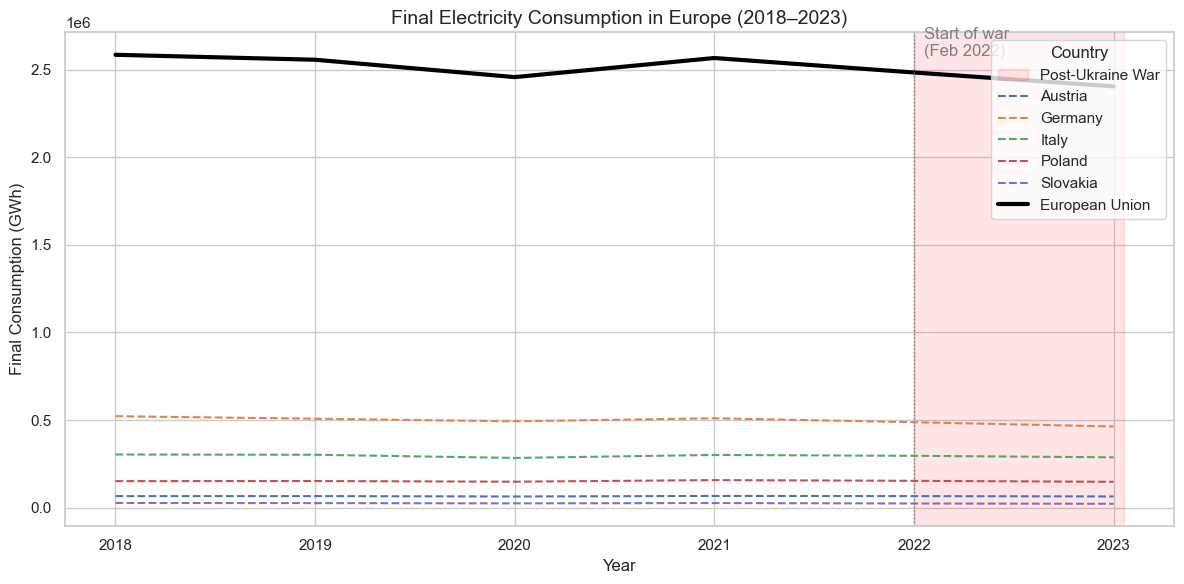

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("imports-exports-fc.total.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Filter for Final Consumption only
fc = df[df['nrg_bal'] == 'Final consumption'].copy()
# Rename for convenience
fc['Year'] = pd.to_numeric(fc['TIME_PERIOD'], errors='coerce')
fc['Value'] = pd.to_numeric(fc['OBS_VALUE'], errors='coerce')
fc['Country'] = fc['geo']
# Keep only the years you need
fc = fc[fc['Year'].between(2018, 2023)]

# Define focus countries and full EU list
focus_countries = ["Austria", "Slovakia", "Italy", "Germany", "Poland"]
eu_countries = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia',
    'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia',
    'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania',
    'Slovakia', 'Slovenia', 'Spain', 'Sweden'
]

# Aggregate EU-wide final consumption
eu_fc = fc[fc['Country'].isin(eu_countries)]
eu_summary = eu_fc.groupby('Year')['Value'].sum().reset_index()
eu_summary['Country'] = 'European Union'

# Extract the five focus countries
focus_df = fc[fc['Country'].isin(focus_countries)]

# Combine for plotting
combined = pd.concat([focus_df[['Country','Year','Value']], eu_summary], ignore_index=True)

# Plot with seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Shade post-war period
plt.axvspan(2022, 2023.05, color='red', alpha=0.1, label='Post-Ukraine War')

# Draw each series
for country in combined['Country'].unique():
    subset = combined[combined['Country'] == country]
    if country == "European Union":
        sns.lineplot(data=subset, x='Year', y='Value',
                     label=country, linewidth=3, color='black')
    else:
        sns.lineplot(data=subset, x='Year', y='Value',
                     label=country, linewidth=1.5, linestyle='--')

# Mark start of war
plt.axvline(2022, color='grey', linestyle=':', linewidth=1)
plt.text(2022 + 0.05, plt.ylim()[1]*0.95, 'Start of war\n(Feb 2022)', color='grey')

# Final touches
plt.title("Final Electricity Consumption in Europe (2018–2023)", fontsize=14)
plt.ylabel("Final Consumption (GWh)")
plt.xlabel("Year")
plt.legend(title="Country", loc='upper right')
plt.tight_layout()
plt.show()


Même graphique que le précdent, mais normalisé

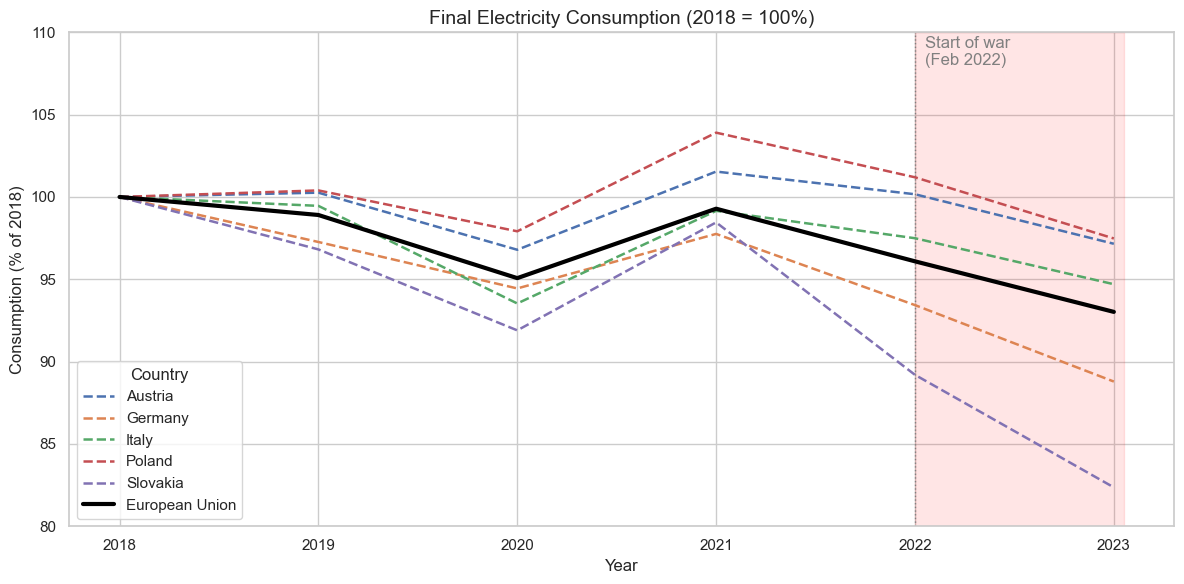

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load & rename columns
df = pd.read_csv("imports-exports-fc.total.csv")
df.columns = df.columns.str.strip()

# 2. Keep only annual final‐consumption data
df = df[df["freq"] == "Annual"]
df = df[df["nrg_bal"] == "Final consumption"]

# 3. Map to convenient names and types
df["Year"]    = pd.to_numeric(df["TIME_PERIOD"], errors="coerce")
df["Value"]   = pd.to_numeric(df["OBS_VALUE"],   errors="coerce")
df["Country"] = df["geo"].str.strip()

# 4. Filter years 2018–2023
df = df[df["Year"].between(2018, 2023)]

# 5. Define focus & EU countries
focus_countries = ["Austria", "Slovakia", "Italy", "Germany", "Poland"]
eu_countries = [
    'Austria','Belgium','Bulgaria','Croatia','Cyprus','Czechia','Denmark','Estonia',
    'Finland','France','Germany','Greece','Hungary','Ireland','Italy','Latvia',
    'Lithuania','Luxembourg','Malta','Netherlands','Poland','Portugal','Romania',
    'Slovakia','Slovenia','Spain','Sweden'
]

# 6. Aggregate EU total
eu_df = df[df["Country"].isin(eu_countries)]
eu_summary = eu_df.groupby("Year")["Value"].sum().reset_index()
eu_summary["Country"] = "European Union"

# 7. Extract focus countries
focus_df = df[df["Country"].isin(focus_countries)][["Country","Year","Value"]]

# 8. Combine & normalize to 2018=100%
combined = pd.concat([focus_df, eu_summary], ignore_index=True)
base = combined[combined["Year"] == 2018][["Country","Value"]].rename(columns={"Value":"Base"})
norm = combined.merge(base, on="Country")
norm["Pct_of_2018"] = norm["Value"] / norm["Base"] * 100

# 9. Plot
sns.set(style="whitegrid")
plt.figure(figsize=(12,6))

# shade post-war
plt.axvspan(2022, 2023.05, color="red", alpha=0.1)
plt.axvline(2022, color="grey", linestyle=":", linewidth=1)
plt.text(2022+0.05, 108, "Start of war\n(Feb 2022)", color="grey")

# lines
for country in norm["Country"].unique():
    sub = norm[norm["Country"] == country]
    if country == "European Union":
        sns.lineplot(data=sub, x="Year", y="Pct_of_2018",
                     label=country, linewidth=3, color="black")
    else:
        sns.lineplot(data=sub, x="Year", y="Pct_of_2018",
                     label=country, linewidth=1.8, linestyle="--")

# formatting
plt.title("Final Electricity Consumption (2018 = 100%)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Consumption (% of 2018)")
plt.ylim(80, 110)
plt.legend(title="Country", loc="lower left")
plt.tight_layout()
plt.show()


4ème graphique, qui affiche les emissions de GHG en fonction du temps, avec la moyenne de l'UE puis les 5 pays qui sont plus touchés

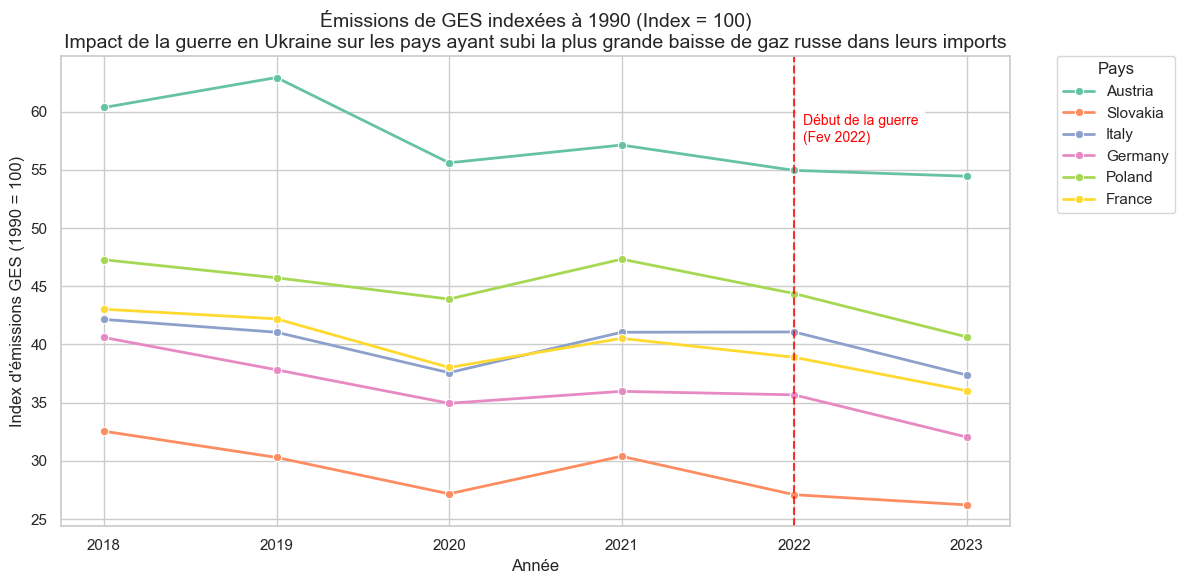

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")

# Load your data
file_path = "GHG-EU.csv"  # Replace with your file path
df = pd.read_csv(file_path)

# Filter for relevant countries and years
countries = ['Austria', 'Slovakia', 'Italy', 'Germany', 'Poland', 'France']
df = df[df['geo'].isin(countries)]
df = df[df['TIME_PERIOD'].between(2018, 2023)]

# Pivot for plotting
pivot_df = df.pivot_table(index='TIME_PERIOD', columns='geo', values='OBS_VALUE', aggfunc='mean')


# Plot
plt.figure(figsize=(12, 6))
palette = sns.color_palette("Set2", n_colors=len(countries))

for idx, country in enumerate(countries):
    sns.lineplot(
        x=pivot_df.index,
        y=pivot_df[country],
        label=country,
        marker='o',
        linewidth=2,
        color=palette[idx]
    )

# Ukraine war marker
war_start_year = 2022
plt.axvline(x=war_start_year, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
plt.text(war_start_year + 0.05, plt.ylim()[1] - 5, 'Début de la guerre\n(Fev 2022)', color='red',
         fontsize=10, ha='left', va='top', backgroundcolor='white')

# Title and labels
plt.title("Émissions de GES indexées à 1990 (Index = 100)\nImpact de la guerre en Ukraine sur les pays ayant subi la plus grande baisse de gaz russe dans leurs imports", fontsize=14)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Index d'émissions GES (1990 = 100)", fontsize=12)

# Legend outside
plt.legend(title="Pays", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Tight layout and show
plt.tight_layout()
plt.show()



prod ener renouvlables en europe


C:\Users\lamar\AppData\Local\Temp\ipykernel_11608\487586302.py:10: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


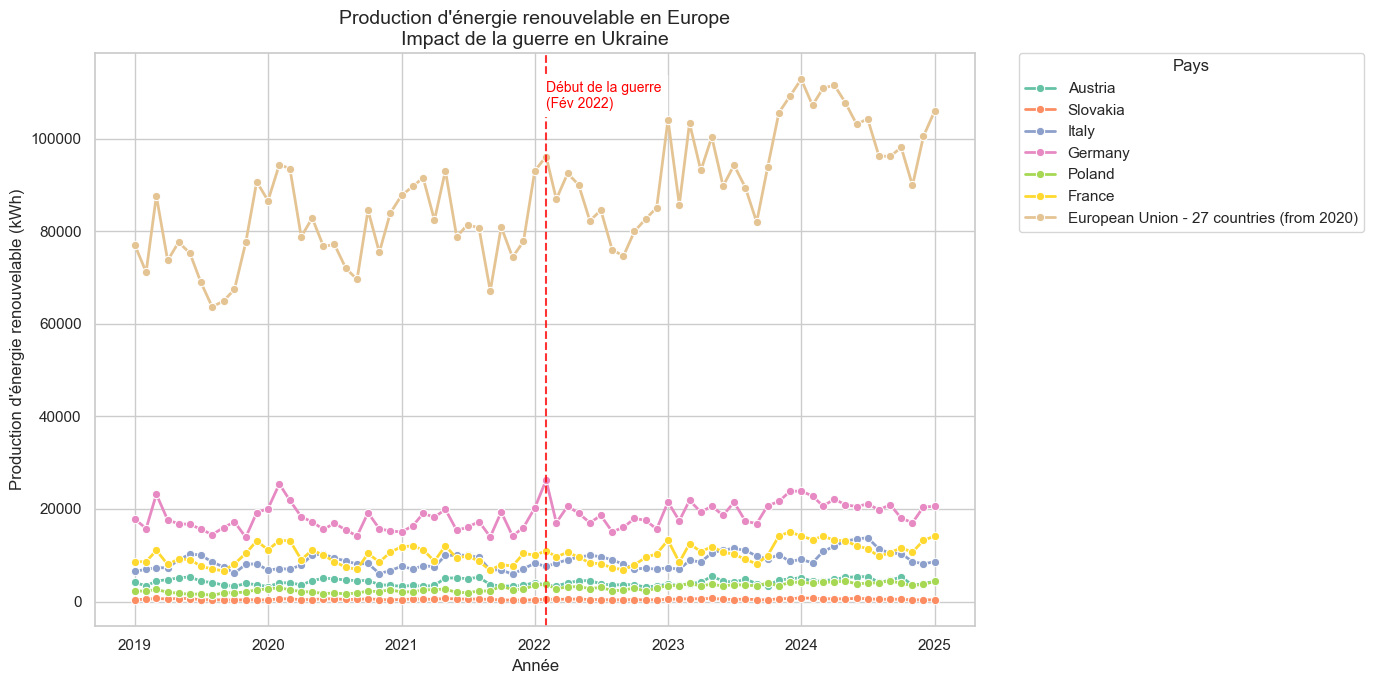

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")

# Load your data
file_path = "production-by-fuel-type-monthly.csv"  # Replace with your actual file path
df = pd.read_csv(file_path)

# --- FILTERS ---
# Countries of interest
countries = ['Austria', 'Slovakia', 'Italy', 'Germany', 'Poland', 'France', 'European Union - 27 countries (from 2020)']

# Convert TIME_PERIOD to datetime if it's not already
df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'])

# Filter for relevant countries, energy type, and time range
df = df[
    (df['geo'].isin(countries)) &
    (df['siec'] == 'Renewables and biofuels') &
    (df['TIME_PERIOD'].between('2019-01-01', '2025-01-01'))
]

# Pivot for plotting (monthly data)
pivot_df = df.pivot_table(index='TIME_PERIOD', columns='geo', values='OBS_VALUE', aggfunc='sum')

# --- PLOT ---
plt.figure(figsize=(14, 7))
palette = sns.color_palette("Set2", n_colors=len(countries))

for idx, country in enumerate(countries):
    if country in pivot_df.columns:
        sns.lineplot(
            x=pivot_df.index,
            y=pivot_df[country],
            label=country,
            marker='o',
            linewidth=2,
            color=palette[idx]
        )

# Ukraine war marker (February 2022)
war_start_date = pd.to_datetime("2022-02-01")
plt.axvline(x=war_start_date, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
plt.text(war_start_date, plt.ylim()[1]*0.95, 'Début de la guerre\n(Fév 2022)', color='red',
         fontsize=10, ha='left', va='top', backgroundcolor='white')

# Titles and labels
plt.title("Production d'énergie renouvelable en Europe\nImpact de la guerre en Ukraine", fontsize=14)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Production d'énergie renouvelable (kWh)", fontsize=12)

# Legend outside
plt.legend(title="Pays", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Format x-axis as years
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()


Graph précédent normalisé pour voir les écarts à la moyenne

C:\Users\lamar\AppData\Local\Temp\ipykernel_11608\2436547347.py:10: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


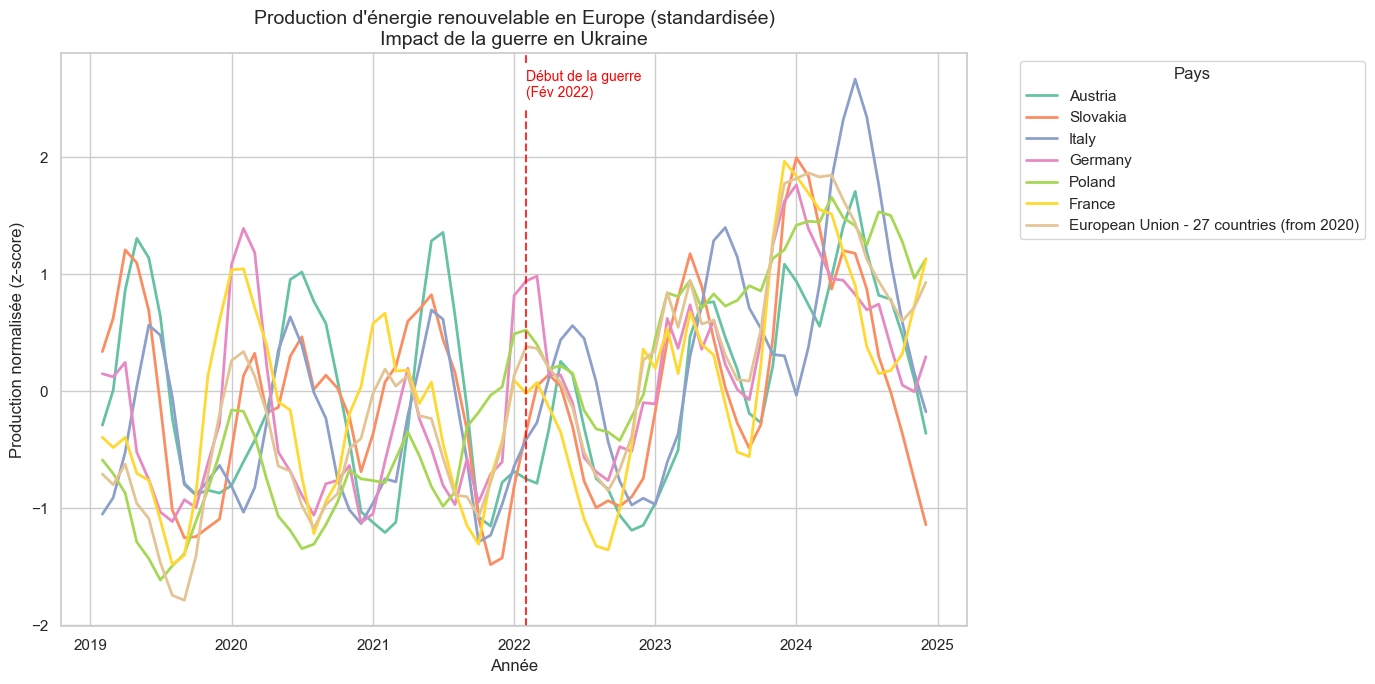

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")

# Load data
file_path = "production-by-fuel-type-monthly.csv"  # Remplace par le bon chemin
df = pd.read_csv(file_path)

# Filtrer les pays et les années
countries = ['Austria', 'Slovakia', 'Italy', 'Germany', 'Poland', 'France', 'European Union - 27 countries (from 2020)']
df = df[df['geo'].isin(countries)]

# Filtrer uniquement les énergies renouvelables
df = df[df['siec'] == 'Renewables and biofuels']

# S'assurer que les dates sont bien interprétées
df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'])

# Garder une plage temporelle pertinente
df = df[(df['TIME_PERIOD'] >= '2019-01-01') & (df['TIME_PERIOD'] <= '2025-01-01')]

# Pivot pour avoir une table avec pays en colonnes et temps en index
pivot_df = df.pivot_table(index='TIME_PERIOD', columns='geo', values='OBS_VALUE', aggfunc='mean')

# Standardisation (z-score)
pivot_std = (pivot_df - pivot_df.mean()) / pivot_df.std()

# Moyenne glissante sur 3 mois pour lisser les courbes
pivot_smoothed = pivot_std.rolling(window=3, center=True).mean()

# Tracer le graphique
plt.figure(figsize=(14, 7))
palette = sns.color_palette("Set2", n_colors=len(countries))

for idx, country in enumerate(countries):
    sns.lineplot(
        x=pivot_smoothed.index,
        y=pivot_smoothed[country],
        label=country,
        linewidth=2,
        color=palette[idx]
    )

# Ligne verticale pour la guerre en Ukraine
war_start = pd.to_datetime('2022-02-01')
plt.axvline(x=war_start, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
plt.text(war_start, plt.ylim()[1] * 0.95, 'Début de la guerre\n(Fév 2022)',
         color='red', fontsize=10, ha='left', va='top', backgroundcolor='white')

# Titre et étiquettes
plt.title("Production d'énergie renouvelable en Europe (standardisée)\nImpact de la guerre en Ukraine", fontsize=14)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Production normalisée (z-score)", fontsize=12)

# Légende
plt.legend(title="Pays", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Écart-type p/r à la moyenne mensuelle

C:\Users\lamar\AppData\Local\Temp\ipykernel_11608\1167261459.py:10: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


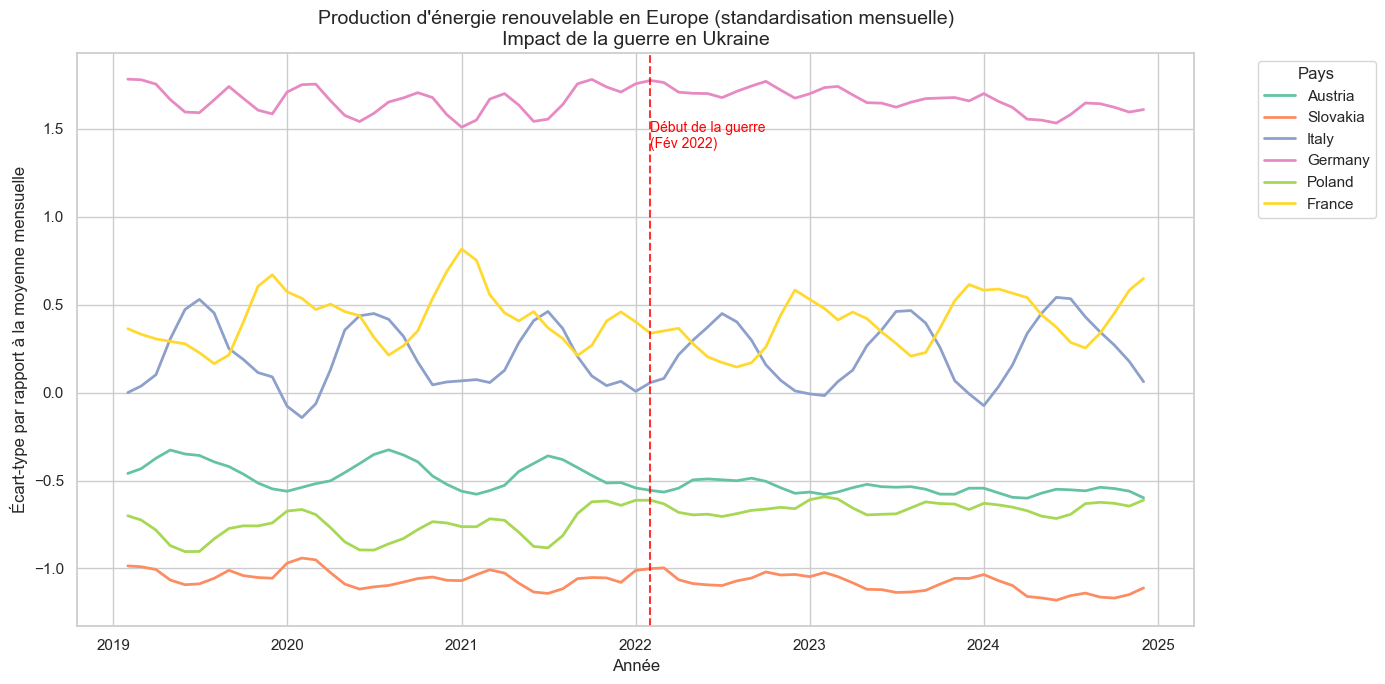

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")

# Load data
file_path = "production-by-fuel-type-monthly.csv"
df = pd.read_csv(file_path)

# Liste des pays
countries = ['Austria', 'Slovakia', 'Italy', 'Germany', 'Poland', 'France']

# Filtrer les énergies renouvelables et les pays
df = df[df['siec'] == 'Renewables and biofuels']
df = df[df['geo'].isin(countries)]

# Dates au bon format
df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'])

# Garder plage temporelle pertinente
df = df[(df['TIME_PERIOD'] >= '2019-01-01') & (df['TIME_PERIOD'] <= '2025-01-01')]

# Pivot (index = date, colonnes = pays)
pivot_df = df.pivot_table(index='TIME_PERIOD', columns='geo', values='OBS_VALUE', aggfunc='mean')

# Calcul de la moyenne et écart-type mensuel (ligne par ligne)
row_means = pivot_df.mean(axis=1)
row_stds = pivot_df.std(axis=1)

# Standardisation par mois
pivot_std = (pivot_df.sub(row_means, axis=0)).div(row_stds, axis=0)

# Moyenne glissante sur 3 mois
pivot_smoothed = pivot_std.rolling(window=3, center=True).mean()

# Tracer le graphique
plt.figure(figsize=(14, 7))
palette = sns.color_palette("Set2", n_colors=len(countries))

for idx, country in enumerate(countries):
    sns.lineplot(
        x=pivot_smoothed.index,
        y=pivot_smoothed[country],
        label=country,
        linewidth=2,
        color=palette[idx]
    )

# Ligne verticale pour la guerre en Ukraine
war_start = pd.to_datetime('2022-02-01')
plt.axvline(x=war_start, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
plt.text(war_start, plt.ylim()[1] * 0.80, 'Début de la guerre\n(Fév 2022)',
         color='red', fontsize=10, ha='left', va='top', backgroundcolor='none')

# Titres et étiquettes
plt.title("Production d'énergie renouvelable en Europe (standardisation mensuelle)\nImpact de la guerre en Ukraine", fontsize=14)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Écart-type par rapport à la moyenne mensuelle", fontsize=12)

# Légende
plt.legend(title="Pays", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


BON Part des renouvelables dans le mix énergétique (écart-type par rapport à la moyenne mensuelle européene)


C:\Users\lamar\AppData\Local\Temp\ipykernel_11608\1982038259.py:10: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_prod = pd.read_csv(prod_path)
C:\Users\lamar\AppData\Local\Temp\ipykernel_11608\1982038259.py:86: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  plt.tight_layout()
C:\Users\lamar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


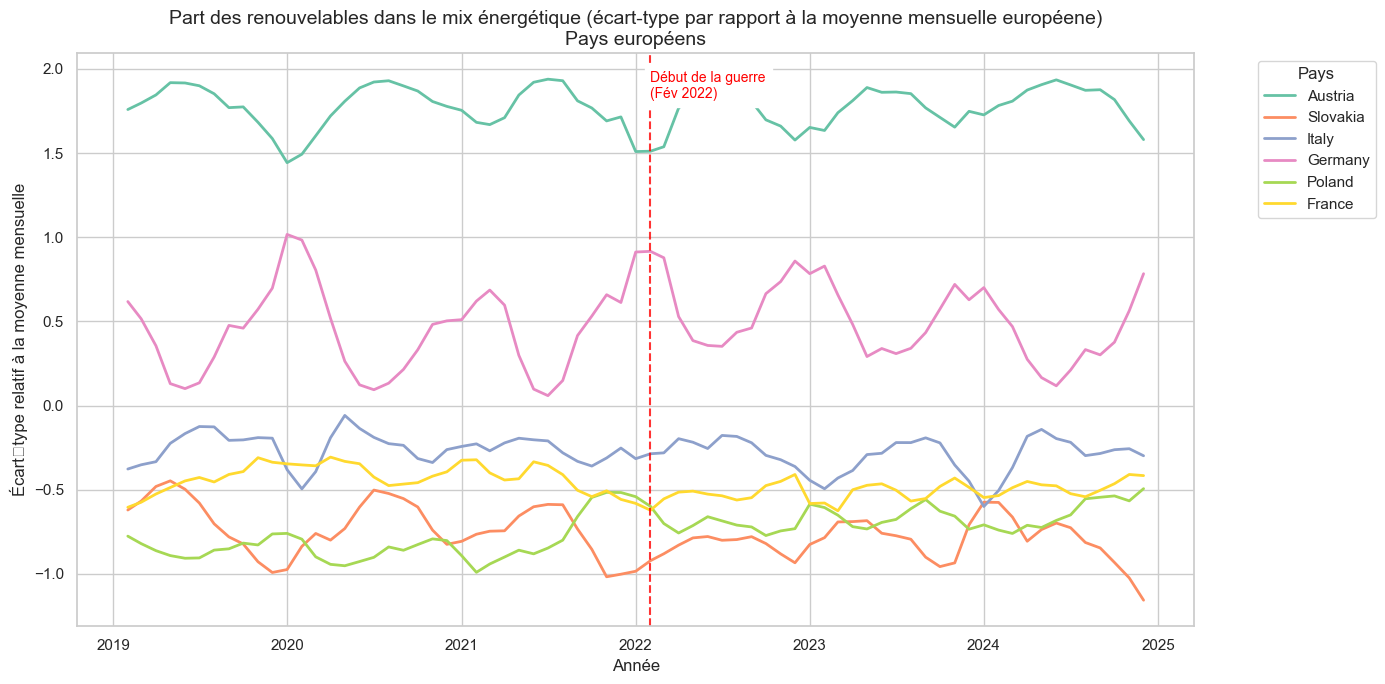

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Style
sns.set_theme(style="whitegrid")

# 2) Charger la production renouvelable
prod_path = "production-by-fuel-type-monthly.csv"
df_prod = pd.read_csv(prod_path)

# 3) Charger la consommation totale
cons_path = "imports-exports-av.fr.consum-monthly.csv"
df_cons = pd.read_csv(cons_path)

# 4) Pays et période
countries = ['Austria', 'Slovakia', 'Italy', 'Germany', 'Poland', 'France']
start, end = '2019-01-01', '2025-01-01'

# 5) Filtrer la production renouvelable
df_prod = df_prod[
    (df_prod['geo'].isin(countries)) &
    (df_prod['siec'] == 'Renewables and biofuels')
]
df_prod['TIME_PERIOD'] = pd.to_datetime(df_prod['TIME_PERIOD'])
df_prod = df_prod[(df_prod['TIME_PERIOD'] >= start) & (df_prod['TIME_PERIOD'] <= end)]

# 6) Filtrer la consommation totale
#    ici j'assume que DATAFLOW=="Consumption" marque la consommation finale
df_cons = df_cons[
    (df_cons['geo'].isin(countries)) &
    (df_cons['nrg_bal'] == 'Available to internal market')
]
df_cons['TIME_PERIOD'] = pd.to_datetime(df_cons['TIME_PERIOD'])
df_cons = df_cons[(df_cons['TIME_PERIOD'] >= start) & (df_cons['TIME_PERIOD'] <= end)]

# 7) Pivot tables : index = mois, colonnes = pays
pivot_prod = df_prod.pivot_table(
    index='TIME_PERIOD',
    columns='geo',
    values='OBS_VALUE',
    aggfunc='sum'
)
pivot_cons = df_cons.pivot_table(
    index='TIME_PERIOD',
    columns='geo',
    values='OBS_VALUE',
    aggfunc='sum'
)

# 8) Calcul du pourcentage de renouvelables dans le mix
share = (pivot_prod / pivot_cons) * 100  # en %

# 9) Standardisation par mois (z-score autour de la moyenne mensuelle)
monthly_mean = share.mean(axis=1)
monthly_std  = share.std(axis=1)
share_z = share.sub(monthly_mean, axis=0).div(monthly_std, axis=0)

# 10) Lissage 3 mois
share_smoothed = share_z.rolling(window=3, center=True).mean()

# 11) Tracé
plt.figure(figsize=(14, 7))
palette = sns.color_palette("Set2", n_colors=len(countries))

for idx, country in enumerate(countries):
    sns.lineplot(
        x=share_smoothed.index,
        y=share_smoothed[country],
        label=country,
        linewidth=2,
        color=palette[idx]
    )

# Repère guerre Ukraine
war_start = pd.to_datetime('2022-02-01')
plt.axvline(x=war_start, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
plt.text(war_start, plt.ylim()[1] * 0.95, 'Début de la guerre\n(Fév 2022)',
         color='red', fontsize=10, ha='left', va='top', backgroundcolor='white')

# Titres et légendes
plt.title("Part des renouvelables dans le mix énergétique (écart-type par rapport à la moyenne mensuelle européene)\nPays européens", fontsize=14)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Écart‑type relatif à la moyenne mensuelle", fontsize=12)
plt.legend(title="Pays", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


BON Score Z par rapport à moyenne saisonnière de la part de renouvlables dans le mix énergétique par pays en fonction du temps

C:\Users\lamar\AppData\Local\Temp\ipykernel_11608\2740837835.py:9: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_prod = pd.read_csv("production-by-fuel-type-monthly.csv")


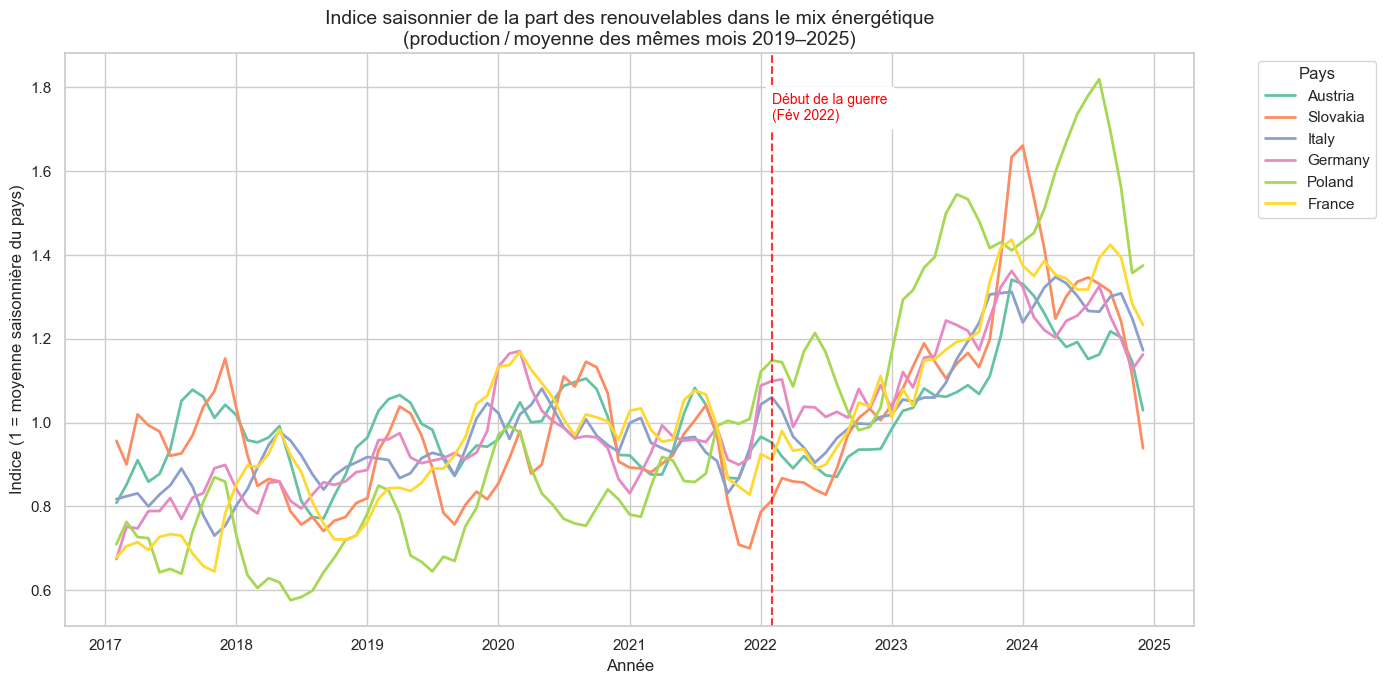

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Style
sns.set_theme(style="whitegrid")

# 2) Charger les deux fichiers
df_prod = pd.read_csv("production-by-fuel-type-monthly.csv")
df_cons = pd.read_csv("imports-exports-av.fr.consum-monthly.csv")

# 3) Paramètres
countries = ['Austria', 'Slovakia', 'Italy', 'Germany', 'Poland', 'France']
start, end = '2017-01-01', '2025-01-01'

# 4) Filtrer production renouvelable
df_prod = df_prod[
    (df_prod['geo'].isin(countries)) &
    (df_prod['siec'] == 'Renewables and biofuels')
].copy()
df_prod['TIME_PERIOD'] = pd.to_datetime(df_prod['TIME_PERIOD'])
df_prod = df_prod[(df_prod['TIME_PERIOD'] >= start) & (df_prod['TIME_PERIOD'] <= end)]

# 5) Filtrer consommation totale (Available to internal market)
df_cons = df_cons[
    (df_cons['geo'].isin(countries)) &
    (df_cons['nrg_bal'] == 'Available to internal market')
].copy()
df_cons['TIME_PERIOD'] = pd.to_datetime(df_cons['TIME_PERIOD'])
df_cons = df_cons[(df_cons['TIME_PERIOD'] >= start) & (df_cons['TIME_PERIOD'] <= end)]

# 6) Pivot tables
pivot_prod = df_prod.pivot_table(
    index='TIME_PERIOD', columns='geo', values='OBS_VALUE', aggfunc='sum'
)
pivot_cons = df_cons.pivot_table(
    index='TIME_PERIOD', columns='geo', values='OBS_VALUE', aggfunc='sum'
)

# 7) Calcul du pourcentage de renouvelables
share = (pivot_prod / pivot_cons) * 100

# 8) Calcul des moyennes saisonnières par pays
#    On regroupe par mois (1 à 12) et on calcule la moyenne sur toutes les années
seasonal_means = share.groupby(share.index.month).mean()

# 9) Normalisation : division du pourcentage par sa moyenne saisonnière
#    Pour chaque ligne de share, on prend seasonal_means.loc[mois, country]
norm = share.copy()
for month in range(1, 13):
    # indices de la date correspondant à ce mois
    mask = norm.index.month == month
    # appliquer la division pour chaque pays
    norm.loc[mask, countries] = norm.loc[mask, countries] / seasonal_means.loc[month, countries]

# 10) Lissage 3 mois
norm_smooth = norm.rolling(window=3, center=True).mean()

# 11) Tracé
plt.figure(figsize=(14, 7))
palette = sns.color_palette("Set2", n_colors=len(countries))

for idx, country in enumerate(countries):
    sns.lineplot(
        x=norm_smooth.index,
        y=norm_smooth[country],
        label=country,
        linewidth=2,
        color=palette[idx]
    )

# Ligne verticale pour le début de la guerre
war_start = pd.to_datetime('2022-02-01')
plt.axvline(x=war_start, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
plt.text(war_start, plt.ylim()[1] * 0.95, 'Début de la guerre\n(Fév 2022)',
         color='red', fontsize=10, ha='left', va='top', backgroundcolor='white')

# Titres et légendes
plt.title(
    "Indice saisonnier de la part des renouvelables dans le mix énergétique\n"
    "(production / moyenne des mêmes mois 2019–2025)",
    fontsize=14
)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Indice (1 = moyenne saisonnière du pays)", fontsize=12)
plt.legend(title="Pays", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Part des combustibles fossiles dans le mix énergétique (écart-type par rapport à la moyenne mensuelle européene)

C:\Users\lamar\AppData\Local\Temp\ipykernel_11608\445484392.py:9: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_prod = pd.read_csv("production-by-fuel-type-monthly.csv")


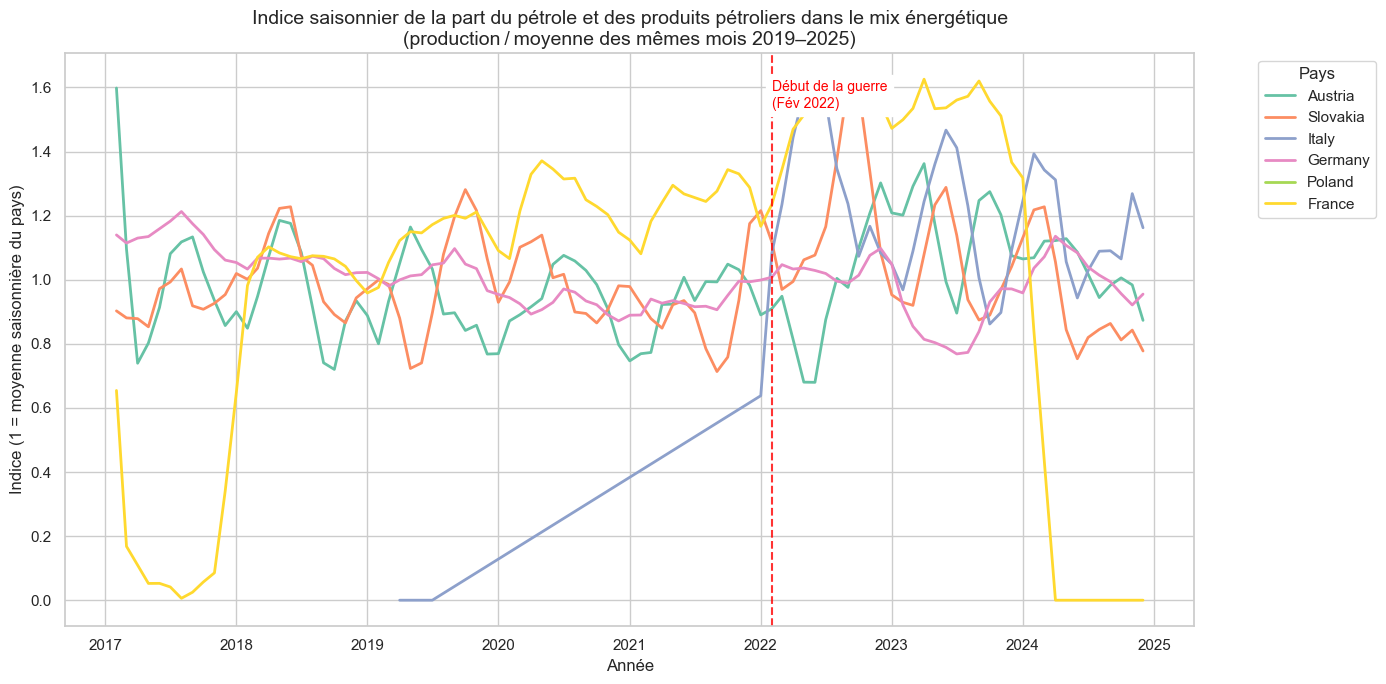

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Style
sns.set_theme(style="whitegrid")

# 2) Charger les deux fichiers
df_prod = pd.read_csv("production-by-fuel-type-monthly.csv")
df_cons = pd.read_csv("imports-exports-av.fr.consum-monthly.csv")

# 3) Paramètres
countries = ['Austria', 'Slovakia', 'Italy', 'Germany', 'Poland', 'France']
start, end = '2017-01-01', '2025-01-01'

# 4) Filtrer production renouvelable
df_prod = df_prod[
    (df_prod['geo'].isin(countries)) &
    (df_prod['siec'] == 'Oil and petroleum products (excluding biofuel portion)')
].copy()
df_prod['TIME_PERIOD'] = pd.to_datetime(df_prod['TIME_PERIOD'])
df_prod = df_prod[(df_prod['TIME_PERIOD'] >= start) & (df_prod['TIME_PERIOD'] <= end)]

# 5) Filtrer consommation totale (Available to internal market)
df_cons = df_cons[
    (df_cons['geo'].isin(countries)) &
    (df_cons['nrg_bal'] == 'Available to internal market')
].copy()
df_cons['TIME_PERIOD'] = pd.to_datetime(df_cons['TIME_PERIOD'])
df_cons = df_cons[(df_cons['TIME_PERIOD'] >= start) & (df_cons['TIME_PERIOD'] <= end)]

# 6) Pivot tables
pivot_prod = df_prod.pivot_table(
    index='TIME_PERIOD', columns='geo', values='OBS_VALUE', aggfunc='sum'
)
pivot_cons = df_cons.pivot_table(
    index='TIME_PERIOD', columns='geo', values='OBS_VALUE', aggfunc='sum'
)

# 7) Calcul du pourcentage de renouvelables
share = (pivot_prod / pivot_cons) * 100

# 8) Calcul des moyennes saisonnières par pays
#    On regroupe par mois (1 à 12) et on calcule la moyenne sur toutes les années
seasonal_means = share.groupby(share.index.month).mean()

# 9) Normalisation : division du pourcentage par sa moyenne saisonnière
#    Pour chaque ligne de share, on prend seasonal_means.loc[mois, country]
norm = share.copy()
for month in range(1, 13):
    # indices de la date correspondant à ce mois
    mask = norm.index.month == month
    # appliquer la division pour chaque pays
    norm.loc[mask, countries] = norm.loc[mask, countries] / seasonal_means.loc[month, countries]

# 10) Lissage 3 mois
norm_smooth = norm.rolling(window=3, center=True).mean()

# 11) Tracé
plt.figure(figsize=(14, 7))
palette = sns.color_palette("Set2", n_colors=len(countries))

for idx, country in enumerate(countries):
    sns.lineplot(
        x=norm_smooth.index,
        y=norm_smooth[country],
        label=country,
        linewidth=2,
        color=palette[idx]
    )

# Ligne verticale pour le début de la guerre
war_start = pd.to_datetime('2022-02-01')
plt.axvline(x=war_start, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
plt.text(war_start, plt.ylim()[1] * 0.95, 'Début de la guerre\n(Fév 2022)',
         color='red', fontsize=10, ha='left', va='top', backgroundcolor='white')

# Titres et légendes
plt.title(
    "Indice saisonnier de la part du pétrole et des produits pétroliers dans le mix énergétique\n"
    "(production / moyenne des mêmes mois 2019–2025)",
    fontsize=14
)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Indice (1 = moyenne saisonnière du pays)", fontsize=12)
plt.legend(title="Pays", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Valeur brute de la qt de pétrole en fct du temps

C:\Users\lamar\AppData\Local\Temp\ipykernel_11608\1788880651.py:10: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


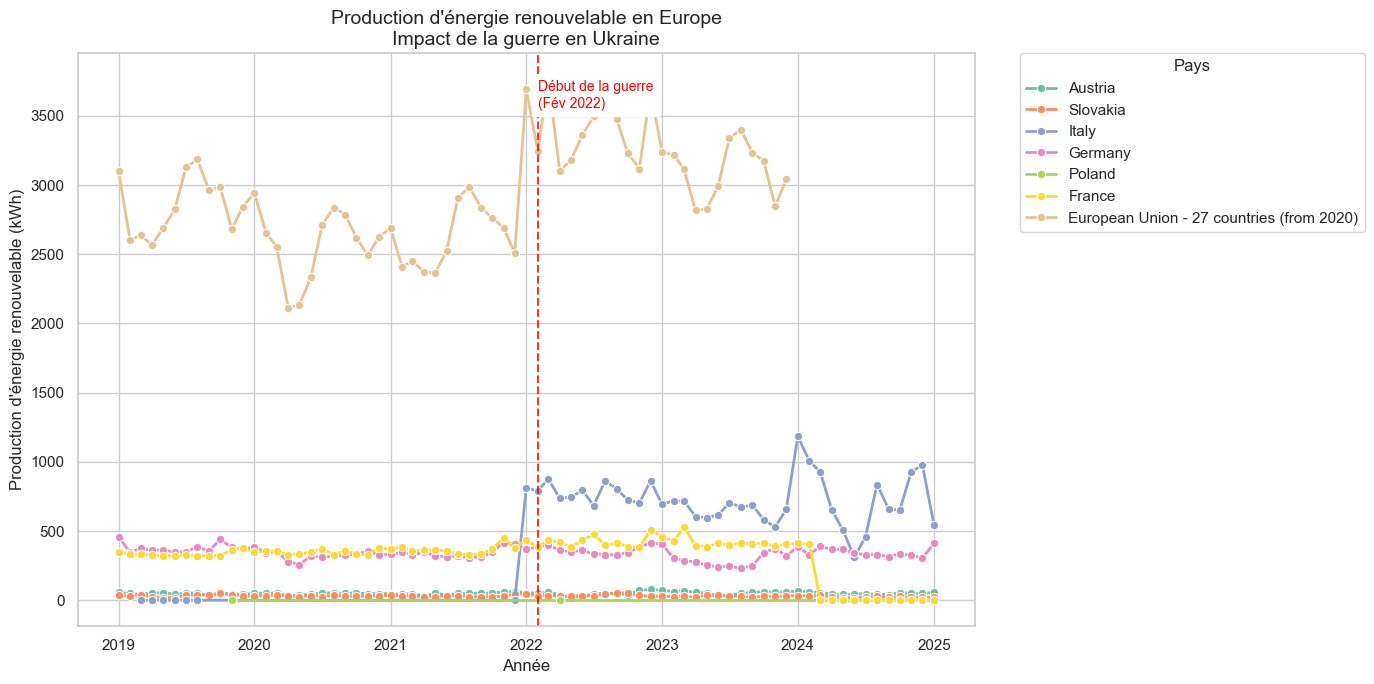

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")

# Load your data
file_path = "production-by-fuel-type-monthly.csv"  # Replace with your actual file path
df = pd.read_csv(file_path)

# --- FILTERS ---
# Countries of interest
countries = ['Austria', 'Slovakia', 'Italy', 'Germany', 'Poland', 'France', 'European Union - 27 countries (from 2020)']

# Convert TIME_PERIOD to datetime if it's not already
df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'])

# Filter for relevant countries, energy type, and time range
df = df[
    (df['geo'].isin(countries)) &
    (df['siec'] == 'Oil and petroleum products (excluding biofuel portion)') &
    (df['TIME_PERIOD'].between('2019-01-01', '2025-01-01'))
]

# Pivot for plotting (monthly data)
pivot_df = df.pivot_table(index='TIME_PERIOD', columns='geo', values='OBS_VALUE', aggfunc='sum')

# --- PLOT ---
plt.figure(figsize=(14, 7))
palette = sns.color_palette("Set2", n_colors=len(countries))

for idx, country in enumerate(countries):
    if country in pivot_df.columns:
        sns.lineplot(
            x=pivot_df.index,
            y=pivot_df[country],
            label=country,
            marker='o',
            linewidth=2,
            color=palette[idx]
        )

# Ukraine war marker (February 2022)
war_start_date = pd.to_datetime("2022-02-01")
plt.axvline(x=war_start_date, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
plt.text(war_start_date, plt.ylim()[1]*0.95, 'Début de la guerre\n(Fév 2022)', color='red',
         fontsize=10, ha='left', va='top', backgroundcolor='white')

# Titles and labels
plt.title("Production d'énergie renouvelable en Europe\nImpact de la guerre en Ukraine", fontsize=14)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Production d'énergie renouvelable (kWh)", fontsize=12)

# Legend outside
plt.legend(title="Pays", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Format x-axis as years
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

+/- BON Production d'énergie pétrolière et de dérivées de produits combustibles en fonction du temps

C:\Users\lamar\AppData\Local\Temp\ipykernel_11608\2099786395.py:10: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


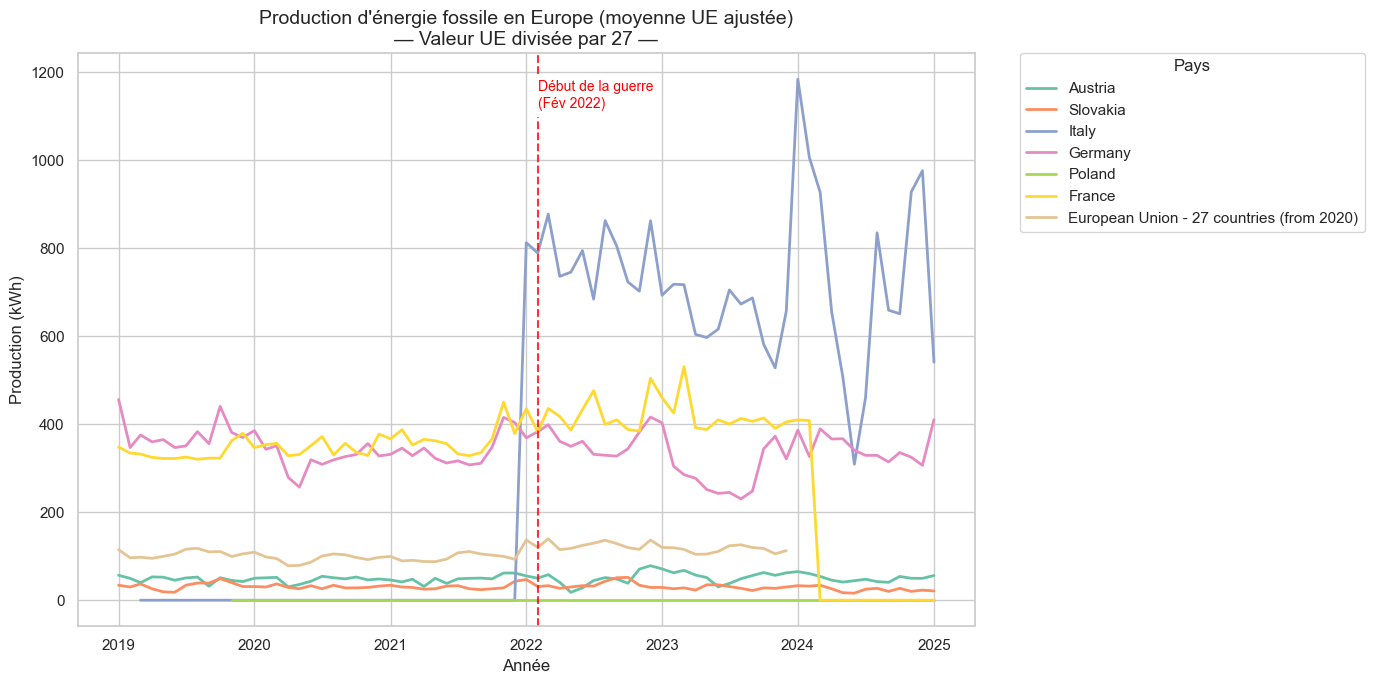

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Style
sns.set_theme(style="whitegrid")

# 2) Charger les données
file_path = "production-by-fuel-type-monthly.csv"
df = pd.read_csv(file_path)

# 3) Préparer les filtres
countries = [
    'Austria', 'Slovakia', 'Italy', 'Germany', 'Poland', 'France',
    'European Union - 27 countries (from 2020)'
]
df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'])
df = df[
    (df['geo'].isin(countries)) &
    (df['siec'] == 'Oil and petroleum products (excluding biofuel portion)') &
    (df['TIME_PERIOD'].between('2019-01-01', '2025-01-01'))
]

# 4) Pivot pour avoir index = mois, colonnes = pays
pivot_df = df.pivot_table(
    index='TIME_PERIOD',
    columns='geo',
    values='OBS_VALUE',
    aggfunc='sum'
)

# 5) Diviser la série UE par 27 pour obtenir la moyenne par pays
eu_col = 'European Union - 27 countries (from 2020)'
if eu_col in pivot_df.columns:
    pivot_df[eu_col] = pivot_df[eu_col] / 27

# 6) Tracé sans points ni lissage
plt.figure(figsize=(14, 7))
palette = sns.color_palette("Set2", n_colors=len(countries))

for idx, country in enumerate(countries):
    if country in pivot_df.columns:
        sns.lineplot(
            x=pivot_df.index,
            y=pivot_df[country],
            label=country,
            linewidth=2,
            color=palette[idx]
        )

# 7) Repère : début de la guerre en Ukraine
war_start = pd.to_datetime("2022-02-01")
plt.axvline(x=war_start, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
plt.text(
    war_start,
    plt.ylim()[1] * 0.95,
    'Début de la guerre\n(Fév 2022)',
    color='red',
    fontsize=10,
    ha='left',
    va='top',
    backgroundcolor='white'
)

# 8) Titres et labels
plt.title(
    "Production d'énergie fossile en Europe (moyenne UE ajustée)\n"
    "— Valeur UE divisée par 27 —",
    fontsize=14
)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Production (kWh)", fontsize=12)

# 9) Légende en-dehors
plt.legend(title="Pays", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# 10) Format de l'axe des X en années
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()


FOnction

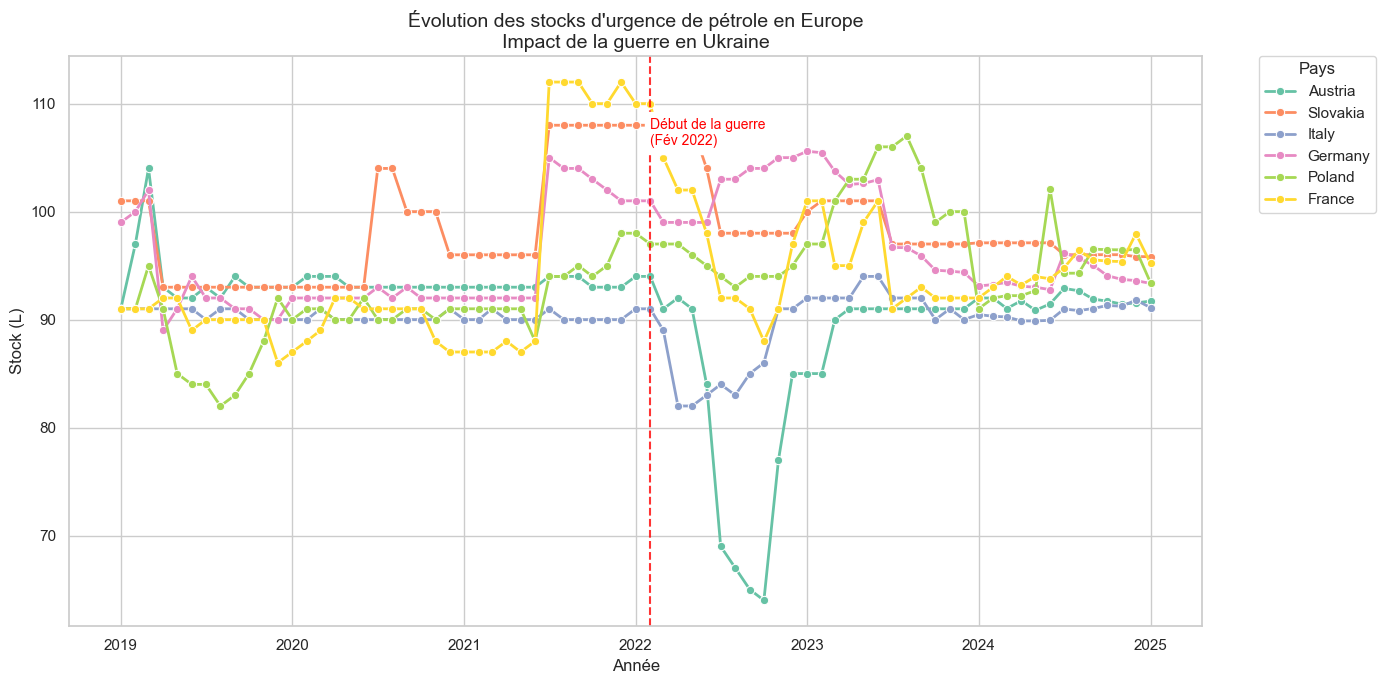

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")

# Load your data
file_path = "emergency_oilstocks_monthly.csv"  # Replace with your actual file path
df = pd.read_csv(file_path)

# --- FILTERS ---
# Countries of interest
countries = ['Austria', 'Slovakia', 'Italy', 'Germany', 'Poland', 'France', 'European Union - 27 countries (from 2020)']

# Convert TIME_PERIOD to datetime if it's not already
df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'])

# Filter for relevant countries, energy type, and time range
df = df[
    (df['geo'].isin(countries)) &
    (df['stk_flow'] == 'Emergency Stocks held by the MS in accordance with the EU Directive (in Days Equivalent)') &
    (df['TIME_PERIOD'].between('2019-01-01', '2025-01-01'))
]

# Pivot for plotting (monthly data)
pivot_df = df.pivot_table(index='TIME_PERIOD', columns='geo', values='OBS_VALUE', aggfunc='sum')

# --- PLOT ---
plt.figure(figsize=(14, 7))
palette = sns.color_palette("Set2", n_colors=len(countries))

for idx, country in enumerate(countries):
    if country in pivot_df.columns:
        sns.lineplot(
            x=pivot_df.index,
            y=pivot_df[country],
            label=country,
            marker='o',
            linewidth=2,
            color=palette[idx]
        )

# Ukraine war marker (February 2022)
war_start_date = pd.to_datetime("2022-02-01")
plt.axvline(x=war_start_date, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
plt.text(war_start_date, plt.ylim()[1]*0.95, 'Début de la guerre\n(Fév 2022)', color='red',
         fontsize=10, ha='left', va='top', backgroundcolor='white')

# Titles and labels
plt.title("Évolution des stocks d'urgence de pétrole en Europe\nImpact de la guerre en Ukraine", fontsize=14)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Stock (L)", fontsize=12)

# Legend outside
plt.legend(title="Pays", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Format x-axis as years
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()